In [1]:
import logging
import os
import copy
import math
import pathlib
from datetime import datetime
import csv
import json

# 3rd Party
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms


In [2]:
# Japanese compatible font
plt.rcParams['font.sans-serif'] = "Microsoft YaHei" 

# Computation device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name(0)}")
    os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
else:
    print(f"Using device: CPU")

Using device: NVIDIA GeForce GTX 1060 6GB


# Utils

In [3]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, nrow=5, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

## Dataset
inoueMashuu/hiragana-dataset

In [4]:
def getInoueMashuuDataset():
    DATASET_DIR = os.path.join('dataset','inoueMashuu_hiragana')
    DATASET_TRAIN_FILE = 'hiragana.csv'
    train_labels = []
    train_images = []
    with open(os.path.join(DATASET_DIR, DATASET_TRAIN_FILE), 'r') as csv_file:
        csvreader = csv.reader(csv_file)
        i = 0
        for data in csvreader:
            train_labels.append(int(data[0]))
            train_images.append([int(a) for a in data[1:]])
            # if i%20==0:
            #     validate_labels.append(int(data[0]))
            #     validate_images.append([int(a) for a in data[1:]])
            # else:
            #     train_labels.append(int(data[0]))
            #     train_images.append([int(a) for a in data[1:]])
            # i += 1
    train_images = torch.tensor(train_images, dtype=torch.float32).reshape(-1,32,32).to(device)
    train_labels = torch.tensor(train_labels, dtype=torch.int64).to(device)
    # validate_images = torch.tensor(validate_images, dtype=torch.float32).reshape(-1,32,32).to(device)
    # validate_labels = torch.tensor(validate_labels, dtype=torch.int64).to(device)
    print(f"Training Set: Input shape: {train_images.shape}. Output shape: {train_labels.shape}")
    # print(f"Validating Set: Input shape: {validate_images.shape}. Output shape: {validate_labels.shape}")

    # Add one dimension for channel
    train_images = train_images.unsqueeze(1)
    print(f"Training Set: Input shape: {train_images.shape}")
    # validate_images = validate_images.unsqueeze(1)
    # print(f"Validating Set: Input shape: {validate_images.shape}")

    # shift pixel values into [-1,1]
    def shiftInputImage(images):
        return (images-128)/128
        
    train_images = shiftInputImage(train_images)
    # validate_images = shiftInputImage(validate_images)

    torch.cuda.empty_cache() 

    return train_images, train_labels, None, None

In [5]:
# train_images, train_labels, _, _ = getInoueMashuuDataset()

In [6]:
def getETLDataset():
    DATASET_DIR = os.path.join('dataset','ETL_8B')
    DATASET_TRAIN_FILE = 'ETL8B2C1.csv'
    train_labels = []
    train_images = []
    with open(os.path.join(DATASET_DIR, DATASET_TRAIN_FILE), 'r') as csv_file:
        csvreader = csv.reader(csv_file)
        for data in csvreader:
            train_labels.append(int(data[0]))
            train_images.append([int(a) for a in data[1:]])
    train_images = torch.tensor(train_images, dtype=torch.float32).reshape(-1,32,32).to(device)
    train_labels = torch.tensor(train_labels, dtype=torch.int64).to(device)

    # Add one dimension for channel
    train_images = train_images.unsqueeze(1)
    print(f"Training Set: Input shape: {train_images.shape}")

    print(f"Max pixel value: {train_images.max()}, min: {train_images.min()}")

    # shift pixel values into [-1,1]
    def shiftInputImage(images):
        return (images-0.5)/0.5
        
    train_images = shiftInputImage(train_images)
    print(f"transformed: Max pixel value: {train_images.max()}, min: {train_images.min()}")

    torch.cuda.empty_cache() 

    return train_images, train_labels, None, None

In [7]:
train_images, train_labels, _, _ = getETLDataset()

Training Set: Input shape: torch.Size([7360, 1, 32, 32])
Max pixel value: 1.0, min: 0.0
transformed: Max pixel value: 1.0, min: -1.0


In [51]:
torch.cuda.empty_cache() 
shuffle_idx = torch.randperm(train_images.shape[0])
train_images = train_images[shuffle_idx]
train_labels = train_labels[shuffle_idx]
torch.cuda.empty_cache() 

In [8]:
# CLASS_NUM = torch.unique(train_labels).shape[0]
# print(f"Label class number: {CLASS_NUM}")
# print(torch.unique(train_labels))

# assert torch.unique(validate_labels).shape[0] == CLASS_NUM
CLASS_NUM = 49

# Model

In [9]:
class Diffusion:
    def __init__(self, noise_step=1000, beta_start=1e-4, beta_end=0.02, img_size=64):
        self.noise_step = noise_step
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_step)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t]).reshape(t.shape[0], 1, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t]).reshape(t.shape[0], 1, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        Ɛ = torch.randn_like(x)
        return (
            (torch.mul(sqrt_alpha_hat, x)+torch.mul(sqrt_one_minus_alpha_hat,Ɛ)),
            Ɛ
        )

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_step, size=(n,))

    # denoise process
    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images ...")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(device)
            # for i in tqdm( reversed(range(1, self.noise_step)), position=0):
            for i in reversed(range(1, self.noise_step)):
                t_tensor = (torch.ones(n) * i).long().to(device)
                t = i
                predicted_noise = model(x, t_tensor, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t_tensor, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t]
                alpha_hat = self.alpha_hat[t]
                beta = self.beta[t]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    # in the final iteration, we don't want to add noise back to X0
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

In [10]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb
    
class UNet_Conditional(nn.Module):
    # sf: scaling factor of cnn kernel numbers
    def __init__(self, c_in=1, c_out=1, time_dim=256, num_classes=None, sf=16):
        super().__init__()
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, sf*1)
        self.down1 = Down(sf*1, sf*2)
        self.sa1 = SelfAttention(sf*2, 16)
        self.down2 = Down(sf*2, sf*4)
        self.sa2 = SelfAttention(sf*4, 8)
        self.down3 = Down(sf*4, sf*4)
        self.sa3 = SelfAttention(sf*4, 4)

        self.bot = DoubleConv(sf*4, sf*4)

        self.up1 = Up(sf*4+sf*4, sf*2)
        self.sa4 = SelfAttention(sf*2, 8)
        self.up2 = Up(sf*2+sf*2, sf*1)
        self.sa5 = SelfAttention(sf*1, 16)
        self.up3 = Up(sf*1+sf*1, sf*1)
        self.sa6 = SelfAttention(sf*1, 32)
        self.outc = nn.Conv2d(sf*1, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    # y: labels (the condition of diffusion)
    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [11]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

# Train

In [37]:
def train(epochs=500, batch_size=6, image_size=32, lr=3e-4, timestep=200, name=None, model=None, use_ema=False):
    if model is None:
        model = UNet_Conditional(c_in=1, c_out=1, num_classes=CLASS_NUM, sf=8).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=image_size, noise_step=200)

    ema = EMA(0.95)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)

    if name is None:
        name = datetime.now().strftime("%Y%m%d_%H%M")
    
    pathlib.Path(f'results/{name}').mkdir(parents=True, exist_ok=True) 

    train_total_step = math.ceil(train_images.shape[0] / batch_size)

    report = {
        'batch_size': batch_size,
        'image_size': image_size,
        'lr': lr,
        'timestep': timestep,
        'use_ema': use_ema,
        'epoch_losses': [],
    }
    epoch_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        train_error = 0
        model.train()
        pbar = tqdm(range(train_total_step))
        for i in pbar:
            optimizer.zero_grad()
            if ((i+1)*batch_size > train_images.shape[0]):
                images = train_images[i*batch_size:]
                labels = train_labels[i*batch_size:]
            else:
                images = train_images[i*batch_size:(i+1)*batch_size]
                labels = train_labels[i*batch_size:(i+1)*batch_size]
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            # if np.random.random() < 0.05: ## ?
            #     labels = None
            predicted_noise = model(x_t, t, labels)
            loss = mse(noise, predicted_noise)
            train_error += loss.item()
            loss.backward()
            optimizer.step()
            if use_ema:
                ema.step_ema(ema_model, model)

            pbar.set_postfix(MSE=(train_error/(i+1)))

            if (epoch * train_total_step + i)%400 == 0:
                labels = torch.unique(train_labels).long().to(device)[:25]
                torch.cuda.empty_cache()
                sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
                save_images(sampled_images, os.path.join("results", f"{name}", f"{(epoch * train_total_step + i)}.jpg"))
                torch.cuda.empty_cache()
                if use_ema:
                    ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
                    save_images(ema_sampled_images, os.path.join("results", f"{name}", f"EMA_{(epoch * train_total_step + i)}.jpg"))
        avg_train_error = (train_error/train_total_step)
        report['epoch_losses'].append(avg_train_error)

        # Save model & training plot
        if (epoch+1)%10 == 0:
            # Save Model
            torch.save(model.state_dict(), os.path.join("results", f"{name}", f"model_epoch_{epoch+1}.pt"))
            # Export Report
            with open(os.path.join("results", f"{name}", "report.json"), "w") as report_f:
                report_f.write(json.dumps(report, indent=4))
            # Plotting the Loss
            plt.plot([ep for ep in range(1,epoch+1+1)], report['epoch_losses'])
            plt.title("Training Loss")
            plt.xlabel("Epoch")
            plt.ylabel("MSE")
            plt.savefig(os.path.join("results", f"{name}", "loss.png"))
        torch.cuda.empty_cache()

    return model

Epoch 0:


100%|███████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.76it/s, MSE=1.1]


Epoch 1:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:22<00:00,  4.51it/s, MSE=0.867]


Epoch 2:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:22<00:00,  4.52it/s, MSE=0.689]


Epoch 3:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.70it/s, MSE=0.594]


Epoch 4:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.36it/s, MSE=0.533]


Epoch 5:


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.49]


Epoch 6:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.38it/s, MSE=0.449]


Epoch 7:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.86it/s, MSE=0.421]


Epoch 8:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.47it/s, MSE=0.397]


Epoch 9:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.48it/s, MSE=0.374]


Epoch 10:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:22<00:00,  4.48it/s, MSE=0.362]


Epoch 11:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:35<00:00,  2.87it/s, MSE=0.347]


Epoch 12:


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.33]


Epoch 13:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:22<00:00,  4.48it/s, MSE=0.319]


Epoch 14:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.309]


Epoch 15:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:35<00:00,  2.86it/s, MSE=0.302]


Epoch 16:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.47it/s, MSE=0.294]


Epoch 17:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.282]


Epoch 18:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.47it/s, MSE=0.277]


Epoch 19:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:35<00:00,  2.87it/s, MSE=0.273]


Epoch 20:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.48it/s, MSE=0.268]


Epoch 21:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.264]


Epoch 22:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.47it/s, MSE=0.259]


Epoch 23:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.86it/s, MSE=0.254]


Epoch 24:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.48it/s, MSE=0.249]


Epoch 25:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:22<00:00,  4.48it/s, MSE=0.243]


Epoch 26:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.47it/s, MSE=0.238]


Epoch 27:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:35<00:00,  2.86it/s, MSE=0.233]


Epoch 28:


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:22<00:00,  4.48it/s, MSE=0.23]


Epoch 29:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.48it/s, MSE=0.225]


Epoch 30:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.222]


Epoch 31:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.86it/s, MSE=0.217]


Epoch 32:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.47it/s, MSE=0.212]


Epoch 33:


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.48it/s, MSE=0.21]


Epoch 34:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.85it/s, MSE=0.206]


Epoch 35:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.47it/s, MSE=0.202]


Epoch 36:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.201]


Epoch 37:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.197]


Epoch 38:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:35<00:00,  2.86it/s, MSE=0.192]


Epoch 39:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.191]


Epoch 40:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.189]


Epoch 41:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.189]


Epoch 42:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.85it/s, MSE=0.182]


Epoch 43:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.182]


Epoch 44:


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.18]


Epoch 45:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.176]


Epoch 46:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.86it/s, MSE=0.173]


Epoch 47:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.48it/s, MSE=0.171]


Epoch 48:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.171]


Epoch 49:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.167]


Epoch 50:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.81it/s, MSE=0.167]


Epoch 51:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.162]


Epoch 52:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.35it/s, MSE=0.162]


Epoch 53:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.159]


Epoch 54:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.85it/s, MSE=0.156]


Epoch 55:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.152]


Epoch 56:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.151]


Epoch 57:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.149]


Epoch 58:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.85it/s, MSE=0.146]


Epoch 59:


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.14]


Epoch 60:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.138]


Epoch 61:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.136]


Epoch 62:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.75it/s, MSE=0.132]


Epoch 63:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.28it/s, MSE=0.132]


Epoch 64:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.38it/s, MSE=0.128]


Epoch 65:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.127]


Epoch 66:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:39<00:00,  2.64it/s, MSE=0.124]


Epoch 67:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.21it/s, MSE=0.121]


Epoch 68:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.15it/s, MSE=0.119]


Epoch 69:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.68it/s, MSE=0.118]


Epoch 70:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.34it/s, MSE=0.116]


Epoch 71:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.20it/s, MSE=0.115]


Epoch 72:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.20it/s, MSE=0.114]


Epoch 73:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.70it/s, MSE=0.112]


Epoch 74:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.20it/s, MSE=0.111]


Epoch 75:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.21it/s, MSE=0.108]


Epoch 76:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.18it/s, MSE=0.107]


Epoch 77:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.79it/s, MSE=0.107]


Epoch 78:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.106]


Epoch 79:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.26it/s, MSE=0.101]


Epoch 80:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.20it/s, MSE=0.101]


Epoch 81:


100%|███████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.68it/s, MSE=0.1]


Epoch 82:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.19it/s, MSE=0.0994]


Epoch 83:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.0991]


Epoch 84:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.33it/s, MSE=0.0979]


Epoch 85:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.69it/s, MSE=0.0972]


Epoch 86:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.21it/s, MSE=0.096]


Epoch 87:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.35it/s, MSE=0.0949]


Epoch 88:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.0943]


Epoch 89:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.78it/s, MSE=0.0956]


Epoch 90:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.27it/s, MSE=0.093]


Epoch 91:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0926]


Epoch 92:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0937]


Epoch 93:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.81it/s, MSE=0.0918]


Epoch 94:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.21it/s, MSE=0.091]


Epoch 95:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.17it/s, MSE=0.0901]


Epoch 96:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.23it/s, MSE=0.0894]


Epoch 97:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.67it/s, MSE=0.0875]


Epoch 98:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.20it/s, MSE=0.0869]


Epoch 99:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.21it/s, MSE=0.0859]


Epoch 100:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.74it/s, MSE=0.085]


Epoch 101:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0841]


Epoch 102:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.31it/s, MSE=0.0831]


Epoch 103:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.19it/s, MSE=0.0834]


Epoch 104:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.77it/s, MSE=0.0827]


Epoch 105:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0825]


Epoch 106:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0812]


Epoch 107:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0815]


Epoch 108:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.80it/s, MSE=0.0815]


Epoch 109:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.37it/s, MSE=0.0798]


Epoch 110:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.21it/s, MSE=0.0799]


Epoch 111:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.35it/s, MSE=0.0786]


Epoch 112:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.67it/s, MSE=0.0762]


Epoch 113:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.21it/s, MSE=0.0762]


Epoch 114:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.18it/s, MSE=0.0759]


Epoch 115:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.18it/s, MSE=0.0753]


Epoch 116:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.71it/s, MSE=0.0742]


Epoch 117:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.35it/s, MSE=0.0741]


Epoch 118:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.21it/s, MSE=0.0742]


Epoch 119:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.21it/s, MSE=0.0737]


Epoch 120:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:39<00:00,  2.64it/s, MSE=0.0737]


Epoch 121:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.21it/s, MSE=0.0731]


Epoch 122:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.37it/s, MSE=0.0724]


Epoch 123:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.21it/s, MSE=0.072]


Epoch 124:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.65it/s, MSE=0.072]


Epoch 125:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.18it/s, MSE=0.0722]


Epoch 126:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.31it/s, MSE=0.0712]


Epoch 127:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0703]


Epoch 128:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.71it/s, MSE=0.0695]


Epoch 129:


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.33it/s, MSE=0.07]


Epoch 130:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.19it/s, MSE=0.0713]


Epoch 131:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.23it/s, MSE=0.0707]


Epoch 132:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.68it/s, MSE=0.0703]


Epoch 133:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.19it/s, MSE=0.069]


Epoch 134:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0688]


Epoch 135:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.79it/s, MSE=0.0694]


Epoch 136:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0693]


Epoch 137:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.19it/s, MSE=0.0684]


Epoch 138:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0688]


Epoch 139:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.70it/s, MSE=0.0675]


Epoch 140:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0662]


Epoch 141:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.0657]


Epoch 142:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.20it/s, MSE=0.0663]


Epoch 143:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.67it/s, MSE=0.065]


Epoch 144:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.15it/s, MSE=0.0652]


Epoch 145:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0643]


Epoch 146:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.0645]


Epoch 147:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.82it/s, MSE=0.0635]


Epoch 148:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0637]


Epoch 149:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.34it/s, MSE=0.0635]


Epoch 150:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.19it/s, MSE=0.0647]


Epoch 151:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.66it/s, MSE=0.0641]


Epoch 152:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.27it/s, MSE=0.0633]


Epoch 153:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.28it/s, MSE=0.0636]


Epoch 154:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.13it/s, MSE=0.063]


Epoch 155:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.67it/s, MSE=0.0629]


Epoch 156:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.17it/s, MSE=0.0635]


Epoch 157:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.15it/s, MSE=0.063]


Epoch 158:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:25<00:00,  4.05it/s, MSE=0.0627]


Epoch 159:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.65it/s, MSE=0.0632]


Epoch 160:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.12it/s, MSE=0.0635]


Epoch 161:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.16it/s, MSE=0.0629]


Epoch 162:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.38it/s, MSE=0.0623]


Epoch 163:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.79it/s, MSE=0.0622]


Epoch 164:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.38it/s, MSE=0.0621]


Epoch 165:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.35it/s, MSE=0.061]


Epoch 166:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.76it/s, MSE=0.0616]


Epoch 167:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.0611]


Epoch 168:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0601]


Epoch 169:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.34it/s, MSE=0.0607]


Epoch 170:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.80it/s, MSE=0.0609]


Epoch 171:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0615]


Epoch 172:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0612]


Epoch 173:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0602]


Epoch 174:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.82it/s, MSE=0.0603]


Epoch 175:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.37it/s, MSE=0.0601]


Epoch 176:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0611]


Epoch 177:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0605]


Epoch 178:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0599]


Epoch 179:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.059]


Epoch 180:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0594]


Epoch 181:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0613]


Epoch 182:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.79it/s, MSE=0.0615]


Epoch 183:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0625]


Epoch 184:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0616]


Epoch 185:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0594]


Epoch 186:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0589]


Epoch 187:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0586]


Epoch 188:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0571]


Epoch 189:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0572]


Epoch 190:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.81it/s, MSE=0.0569]


Epoch 191:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.38it/s, MSE=0.0578]


Epoch 192:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.38it/s, MSE=0.057]


Epoch 193:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.056]


Epoch 194:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.81it/s, MSE=0.0555]


Epoch 195:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.37it/s, MSE=0.0558]


Epoch 196:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0552]


Epoch 197:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0555]


Epoch 198:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.82it/s, MSE=0.0553]


Epoch 199:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0553]


Epoch 200:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0544]


Epoch 201:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.80it/s, MSE=0.0557]


Epoch 202:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0553]


Epoch 203:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0554]


Epoch 204:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0555]


Epoch 205:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0558]


Epoch 206:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0568]


Epoch 207:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.38it/s, MSE=0.0563]


Epoch 208:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0553]


Epoch 209:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0571]


Epoch 210:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0568]


Epoch 211:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0566]


Epoch 212:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0565]


Epoch 213:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.84it/s, MSE=0.0554]


Epoch 214:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0566]


Epoch 215:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.056]


Epoch 216:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0545]


Epoch 217:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0548]


Epoch 218:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0543]


Epoch 219:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.054]


Epoch 220:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0544]


Epoch 221:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.80it/s, MSE=0.0546]


Epoch 222:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.38it/s, MSE=0.0529]


Epoch 223:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.37it/s, MSE=0.0533]


Epoch 224:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0532]


Epoch 225:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.84it/s, MSE=0.0541]


Epoch 226:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0555]


Epoch 227:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0547]


Epoch 228:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0554]


Epoch 229:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.82it/s, MSE=0.0552]


Epoch 230:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.35it/s, MSE=0.055]


Epoch 231:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.37it/s, MSE=0.0546]


Epoch 232:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.0544]


Epoch 233:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.84it/s, MSE=0.0543]


Epoch 234:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.35it/s, MSE=0.0541]


Epoch 235:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0535]


Epoch 236:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.81it/s, MSE=0.0532]


Epoch 237:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.37it/s, MSE=0.054]


Epoch 238:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.35it/s, MSE=0.0533]


Epoch 239:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.36it/s, MSE=0.0531]


Epoch 240:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.84it/s, MSE=0.0536]


Epoch 241:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.37it/s, MSE=0.0534]


Epoch 242:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0533]


Epoch 243:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.0527]


Epoch 244:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.84it/s, MSE=0.052]


Epoch 245:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0517]


Epoch 246:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0514]


Epoch 247:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0519]


Epoch 248:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.84it/s, MSE=0.0514]


Epoch 249:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0513]


Epoch 250:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0509]


Epoch 251:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0504]


Epoch 252:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0508]


Epoch 253:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0509]


Epoch 254:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0507]


Epoch 255:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0503]


Epoch 256:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.81it/s, MSE=0.0507]


Epoch 257:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0515]


Epoch 258:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0512]


Epoch 259:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.051]


Epoch 260:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.84it/s, MSE=0.0507]


Epoch 261:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0497]


Epoch 262:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0498]


Epoch 263:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.28it/s, MSE=0.0497]


Epoch 264:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.79it/s, MSE=0.0505]


Epoch 265:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0504]


Epoch 266:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0506]


Epoch 267:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0506]


Epoch 268:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0503]


Epoch 269:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.37it/s, MSE=0.0499]


Epoch 270:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0496]


Epoch 271:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.82it/s, MSE=0.0498]


Epoch 272:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0504]


Epoch 273:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0503]


Epoch 274:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0491]


Epoch 275:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.81it/s, MSE=0.0479]


Epoch 276:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.36it/s, MSE=0.0487]


Epoch 277:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.31it/s, MSE=0.0481]


Epoch 278:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.28it/s, MSE=0.0487]


Epoch 279:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.74it/s, MSE=0.0486]


Epoch 280:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0481]


Epoch 281:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0483]


Epoch 282:


100%|██████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.34it/s, MSE=0.05]


Epoch 283:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0513]


Epoch 284:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.052]


Epoch 285:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0517]


Epoch 286:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0499]


Epoch 287:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0502]


Epoch 288:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0487]


Epoch 289:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0479]


Epoch 290:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0476]


Epoch 291:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.82it/s, MSE=0.0478]


Epoch 292:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.38it/s, MSE=0.0472]


Epoch 293:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0472]


Epoch 294:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.048]


Epoch 295:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.80it/s, MSE=0.0479]


Epoch 296:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.37it/s, MSE=0.0483]


Epoch 297:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0486]


Epoch 298:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0468]


Epoch 299:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0479]


Epoch 300:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0478]


Epoch 301:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.048]


Epoch 302:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.79it/s, MSE=0.0478]


Epoch 303:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.37it/s, MSE=0.0472]


Epoch 304:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.0483]


Epoch 305:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0489]


Epoch 306:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.81it/s, MSE=0.0483]


Epoch 307:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.048]


Epoch 308:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.38it/s, MSE=0.0476]


Epoch 309:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.37it/s, MSE=0.047]


Epoch 310:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.78it/s, MSE=0.0468]


Epoch 311:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0465]


Epoch 312:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0463]


Epoch 313:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.046]


Epoch 314:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.80it/s, MSE=0.0459]


Epoch 315:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.32it/s, MSE=0.046]


Epoch 316:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.31it/s, MSE=0.0457]


Epoch 317:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0457]


Epoch 318:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0454]


Epoch 319:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0462]


Epoch 320:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0461]


Epoch 321:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0472]


Epoch 322:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.77it/s, MSE=0.0474]


Epoch 323:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0481]


Epoch 324:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0491]


Epoch 325:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0489]


Epoch 326:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.81it/s, MSE=0.0483]


Epoch 327:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.35it/s, MSE=0.0479]


Epoch 328:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.0469]


Epoch 329:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0468]


Epoch 330:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.79it/s, MSE=0.0465]


Epoch 331:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0459]


Epoch 332:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0464]


Epoch 333:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.84it/s, MSE=0.046]


Epoch 334:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0456]


Epoch 335:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0458]


Epoch 336:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0457]


Epoch 337:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.82it/s, MSE=0.0451]


Epoch 338:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.045]


Epoch 339:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.0454]


Epoch 340:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0453]


Epoch 341:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.75it/s, MSE=0.0449]


Epoch 342:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0449]


Epoch 343:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.045]


Epoch 344:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.36it/s, MSE=0.0447]


Epoch 345:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.82it/s, MSE=0.0448]


Epoch 346:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0454]


Epoch 347:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.0458]


Epoch 348:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.26it/s, MSE=0.0469]


Epoch 349:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.78it/s, MSE=0.0477]


Epoch 350:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0477]


Epoch 351:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0469]


Epoch 352:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.0477]


Epoch 353:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.79it/s, MSE=0.0467]


Epoch 354:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.36it/s, MSE=0.0467]


Epoch 355:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0461]


Epoch 356:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.045]


Epoch 357:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.82it/s, MSE=0.0446]


Epoch 358:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0438]


Epoch 359:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.0438]


Epoch 360:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0439]


Epoch 361:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.75it/s, MSE=0.0435]


Epoch 362:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0431]


Epoch 363:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.39it/s, MSE=0.0431]


Epoch 364:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0433]


Epoch 365:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0434]


Epoch 366:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0431]


Epoch 367:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.41it/s, MSE=0.0433]


Epoch 368:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.82it/s, MSE=0.0432]


Epoch 369:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0437]


Epoch 370:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0436]


Epoch 371:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0435]


Epoch 372:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.84it/s, MSE=0.0439]


Epoch 373:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0445]


Epoch 374:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.35it/s, MSE=0.0448]


Epoch 375:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.40it/s, MSE=0.045]


Epoch 376:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.80it/s, MSE=0.045]


Epoch 377:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0448]


Epoch 378:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.0452]


Epoch 379:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0453]


Epoch 380:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.85it/s, MSE=0.0437]


Epoch 381:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0436]


Epoch 382:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.0428]


Epoch 383:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.0432]


Epoch 384:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.85it/s, MSE=0.0428]


Epoch 385:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.043]


Epoch 386:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.0427]


Epoch 387:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0426]


Epoch 388:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.82it/s, MSE=0.042]


Epoch 389:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.0429]


Epoch 390:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.0436]


Epoch 391:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0427]


Epoch 392:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.84it/s, MSE=0.0431]


Epoch 393:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.0435]


Epoch 394:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.0442]


Epoch 395:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.045]


Epoch 396:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.84it/s, MSE=0.0445]


Epoch 397:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.0445]


Epoch 398:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.42it/s, MSE=0.0447]


Epoch 399:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.0449]


Epoch 400:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.75it/s, MSE=0.0437]


Epoch 401:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.28it/s, MSE=0.0436]


Epoch 402:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.36it/s, MSE=0.0433]


Epoch 403:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.74it/s, MSE=0.0431]


Epoch 404:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.34it/s, MSE=0.0422]


Epoch 405:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.26it/s, MSE=0.0424]


Epoch 406:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.28it/s, MSE=0.042]


Epoch 407:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.70it/s, MSE=0.0425]


Epoch 408:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.27it/s, MSE=0.0432]


Epoch 409:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.27it/s, MSE=0.0423]


Epoch 410:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.26it/s, MSE=0.0423]


Epoch 411:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.71it/s, MSE=0.0421]


Epoch 412:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.26it/s, MSE=0.043]


Epoch 413:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0434]


Epoch 414:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0446]


Epoch 415:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.70it/s, MSE=0.0449]


Epoch 416:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.26it/s, MSE=0.0454]


Epoch 417:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.27it/s, MSE=0.0451]


Epoch 418:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0444]


Epoch 419:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.71it/s, MSE=0.0431]


Epoch 420:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0429]


Epoch 421:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.27it/s, MSE=0.0424]


Epoch 422:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.30it/s, MSE=0.042]


Epoch 423:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0417]


Epoch 424:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0414]


Epoch 425:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0414]


Epoch 426:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0415]


Epoch 427:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0417]


Epoch 428:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0414]


Epoch 429:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0417]


Epoch 430:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0419]


Epoch 431:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0419]


Epoch 432:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.042]


Epoch 433:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.0422]


Epoch 434:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0423]


Epoch 435:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0431]


Epoch 436:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0422]


Epoch 437:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0432]


Epoch 438:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.84it/s, MSE=0.0441]


Epoch 439:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.0434]


Epoch 440:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.43it/s, MSE=0.0441]


Epoch 441:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0436]


Epoch 442:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0431]


Epoch 443:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.45it/s, MSE=0.0435]


Epoch 444:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.46it/s, MSE=0.0429]


Epoch 445:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0424]


Epoch 446:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:36<00:00,  2.83it/s, MSE=0.0423]


Epoch 447:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0418]


Epoch 448:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0421]


Epoch 449:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.44it/s, MSE=0.0421]


Epoch 450:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.77it/s, MSE=0.042]


Epoch 451:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0419]


Epoch 452:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.27it/s, MSE=0.0421]


Epoch 453:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.27it/s, MSE=0.0424]


Epoch 454:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.71it/s, MSE=0.0423]


Epoch 455:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.27it/s, MSE=0.0434]


Epoch 456:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0429]


Epoch 457:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.27it/s, MSE=0.0431]


Epoch 458:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.72it/s, MSE=0.0444]


Epoch 459:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.0433]


Epoch 460:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.26it/s, MSE=0.0435]


Epoch 461:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.26it/s, MSE=0.0435]


Epoch 462:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.71it/s, MSE=0.0427]


Epoch 463:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0418]


Epoch 464:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0417]


Epoch 465:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.0411]


Epoch 466:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.71it/s, MSE=0.041]


Epoch 467:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.26it/s, MSE=0.0407]


Epoch 468:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.26it/s, MSE=0.0411]


Epoch 469:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.70it/s, MSE=0.0401]


Epoch 470:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0407]


Epoch 471:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.0408]


Epoch 472:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.26it/s, MSE=0.0406]


Epoch 473:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.69it/s, MSE=0.0407]


Epoch 474:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.041]


Epoch 475:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.041]


Epoch 476:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.25it/s, MSE=0.0411]


Epoch 477:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.68it/s, MSE=0.041]


Epoch 478:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.0411]


Epoch 479:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.041]


Epoch 480:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.22it/s, MSE=0.0413]


Epoch 481:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:37<00:00,  2.72it/s, MSE=0.0412]


Epoch 482:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:23<00:00,  4.33it/s, MSE=0.0408]


Epoch 483:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.26it/s, MSE=0.0416]


Epoch 484:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.0423]


Epoch 485:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.70it/s, MSE=0.0436]


Epoch 486:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.22it/s, MSE=0.0424]


Epoch 487:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.23it/s, MSE=0.0427]


Epoch 488:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.0419]


Epoch 489:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.70it/s, MSE=0.041]


Epoch 490:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.22it/s, MSE=0.0402]


Epoch 491:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.0401]


Epoch 492:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.23it/s, MSE=0.0402]


Epoch 493:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.68it/s, MSE=0.0405]


Epoch 494:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.23it/s, MSE=0.0406]


Epoch 495:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.23it/s, MSE=0.0398]


Epoch 496:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.23it/s, MSE=0.0403]


Epoch 497:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:38<00:00,  2.69it/s, MSE=0.0402]


Epoch 498:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.24it/s, MSE=0.0404]


Epoch 499:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:24<00:00,  4.22it/s, MSE=0.0409]


{'batch_size': 72, 'image_size': 32, 'lr': 5e-05, 'timestep': 100, 'use_ema': False, 'epoch_losses': [1.0974974094085324, 0.8666600260919738, 0.6889856307251939, 0.5937440673124443, 0.5326791243645751, 0.48952508869680383, 0.4490471470703199, 0.4207371296813187, 0.3971914695304574, 0.37415101805936946, 0.3616100824573665, 0.34656754599034206, 0.3296072953245015, 0.318640793990163, 0.30862422996354333, 0.3015076250416561, 0.2935856723959006, 0.2818672568763344, 0.276702044802962, 0.27270146235100273, 0.2679537641770631, 0.2644559123273035, 0.25893139969376683, 0.25407403302424164, 0.24890269339084625, 0.24293214762673795, 0.23781228513972272, 0.23339223543417106, 0.22976582244183252, 0.2249615999680121, 0.22221855934962487, 0.21716074081300532, 0.21155658812777509, 0.21009592408115424, 0.20608839956880773, 0.20218093693256378, 0.20078406779511462, 0.19662643766518936, 0.1922798995832795, 0.19144637665702302, 0.18861420213886834, 0.188880150757947, 0.1821365623364171, 0.1817181106041936,

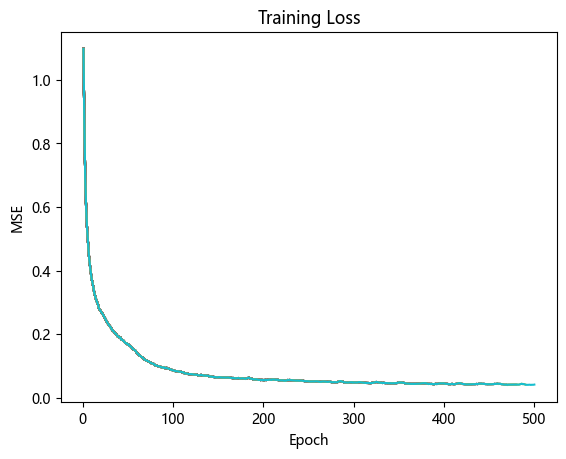

In [13]:
torch.cuda.empty_cache()
train(epochs=500, batch_size=72, image_size=32, lr=5e-5, timestep=100, name="ELB_5e5_t100")


In [53]:
torch.cuda.empty_cache()
trained_model = UNet_Conditional(c_in=1, c_out=1, num_classes=CLASS_NUM, sf=8).to(device)
trained_model.load_state_dict(torch.load(os.path.join("results", "ELB_5e5_t100", "model_epoch_500.pt")))

<All keys matched successfully>

Epoch 0:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:59<00:00,  1.74it/s, MSE=0.0396]


Epoch 1:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.27it/s, MSE=0.0392]


Epoch 2:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.27it/s, MSE=0.0398]


Epoch 3:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.76it/s, MSE=0.039]


Epoch 4:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.25it/s, MSE=0.0388]


Epoch 5:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.27it/s, MSE=0.0393]


Epoch 6:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.26it/s, MSE=0.0387]


Epoch 7:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.75it/s, MSE=0.0385]


Epoch 8:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.25it/s, MSE=0.0388]


Epoch 9:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.26it/s, MSE=0.039]


Epoch 10:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:46<00:00,  2.19it/s, MSE=0.0383]


Epoch 11:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:59<00:00,  1.75it/s, MSE=0.0389]


Epoch 12:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.26it/s, MSE=0.0387]


Epoch 13:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.27it/s, MSE=0.0389]


Epoch 14:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.27it/s, MSE=0.0383]


Epoch 15:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:59<00:00,  1.74it/s, MSE=0.0383]


Epoch 16:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:46<00:00,  2.23it/s, MSE=0.0385]


Epoch 17:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.26it/s, MSE=0.0391]


Epoch 18:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.26it/s, MSE=0.0388]


Epoch 19:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.75it/s, MSE=0.0381]


Epoch 20:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.27it/s, MSE=0.0383]


Epoch 21:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.26it/s, MSE=0.0385]


Epoch 22:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0378]


Epoch 23:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:57<00:00,  1.78it/s, MSE=0.0386]


Epoch 24:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.26it/s, MSE=0.0381]


Epoch 25:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.27it/s, MSE=0.0386]


Epoch 26:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0385]


Epoch 27:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0382]


Epoch 28:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.28it/s, MSE=0.0382]


Epoch 29:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0383]


Epoch 30:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.28it/s, MSE=0.0384]


Epoch 31:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0387]


Epoch 32:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0386]


Epoch 33:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0383]


Epoch 34:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0385]


Epoch 35:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0383]


Epoch 36:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0386]


Epoch 37:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.29it/s, MSE=0.0379]


Epoch 38:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.78it/s, MSE=0.0379]


Epoch 39:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0383]


Epoch 40:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0382]


Epoch 41:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0382]


Epoch 42:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0378]


Epoch 43:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.28it/s, MSE=0.0379]


Epoch 44:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.27it/s, MSE=0.0379]


Epoch 45:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0379]


Epoch 46:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0376]


Epoch 47:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0376]


Epoch 48:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.038]


Epoch 49:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.29it/s, MSE=0.038]


Epoch 50:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0378]


Epoch 51:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0379]


Epoch 52:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0377]


Epoch 53:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0382]


Epoch 54:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0378]


Epoch 55:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.29it/s, MSE=0.0381]


Epoch 56:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0371]


Epoch 57:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0375]


Epoch 58:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:57<00:00,  1.78it/s, MSE=0.0383]


Epoch 59:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.29it/s, MSE=0.0377]


Epoch 60:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0378]


Epoch 61:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.29it/s, MSE=0.0378]


Epoch 62:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.78it/s, MSE=0.0371]


Epoch 63:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.29it/s, MSE=0.0375]


Epoch 64:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.30it/s, MSE=0.0377]


Epoch 65:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0379]


Epoch 66:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0378]


Epoch 67:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0373]


Epoch 68:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0375]


Epoch 69:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.038]


Epoch 70:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0376]


Epoch 71:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0377]


Epoch 72:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.29it/s, MSE=0.0376]


Epoch 73:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.038]


Epoch 74:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0374]


Epoch 75:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0376]


Epoch 76:


100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.29it/s, MSE=0.038]


Epoch 77:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0375]


Epoch 78:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0377]


Epoch 79:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.30it/s, MSE=0.0378]


Epoch 80:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0373]


Epoch 81:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0376]


Epoch 82:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0381]


Epoch 83:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0382]


Epoch 84:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.29it/s, MSE=0.0375]


Epoch 85:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0381]


Epoch 86:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.29it/s, MSE=0.0376]


Epoch 87:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0376]


Epoch 88:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0374]


Epoch 89:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0372]


Epoch 90:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.28it/s, MSE=0.0377]


Epoch 91:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0376]


Epoch 92:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0371]


Epoch 93:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:58<00:00,  1.77it/s, MSE=0.0375]


Epoch 94:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.29it/s, MSE=0.0376]


Epoch 95:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:44<00:00,  2.29it/s, MSE=0.0375]


Epoch 96:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.29it/s, MSE=0.0373]


Epoch 97:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:57<00:00,  1.78it/s, MSE=0.0373]


Epoch 98:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:45<00:00,  2.28it/s, MSE=0.0372]


Epoch 99:


100%|████████████████████████████████████████████████████████████████████| 103/103 [00:46<00:00,  2.23it/s, MSE=0.0376]


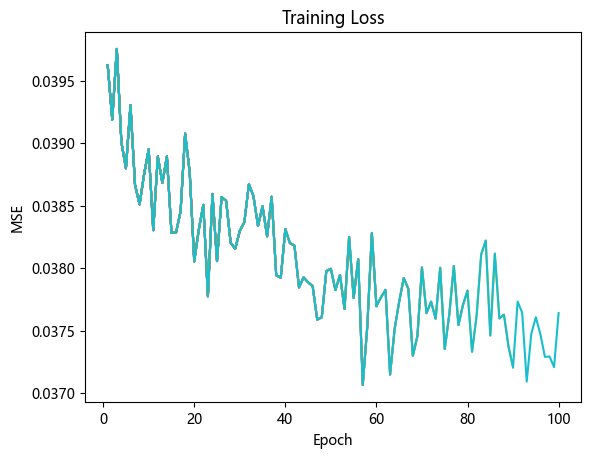

In [54]:
trained_model = train(epochs=100, batch_size=72, image_size=32, lr=1e-5, timestep=100, name="ELB_5e5_t100_continued_1", model=trained_model)

In [59]:
torch.cuda.empty_cache()

## TODO
- why EMA doesn't work? is there outlier?
- cosine scheduler
- higher time step